### 导入一些需要用到的库

In [1]:
import tushare as ts
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

### 获取某股票最近若干天的前复权数据

In [43]:
def get_data(code,end='2018-01-01', duration=365):
    
    # 打印股票的基本信息
    df = ts.get_stock_basics()
    print(df.loc[code][['name', 'industry', 'timeToMarket']])
    
    d1 = datetime.datetime.strptime(end,'%Y-%m-%d')
    d2 = d1 - datetime.timedelta(days=duration)
    start = d2.strftime('%Y-%m-%d')

    return ts.get_h_data(code, start=start, end=end)

### 一个例子 -- 获取数据，保存文件，可视化

In [44]:
code = '300222'

data = get_data(code, duration=365*3)

name                科大智能
industry            电气设备
timeToMarket    20110525
Name: 300222, dtype: object
[Getting data:]############

In [45]:
data.to_csv('stock_data_730.csv')

In [169]:
data = pd.read_csv('stock_data_730.csv')

In [170]:
data.set_index(["date"], inplace=True)

data_sorted = data.sort_index()

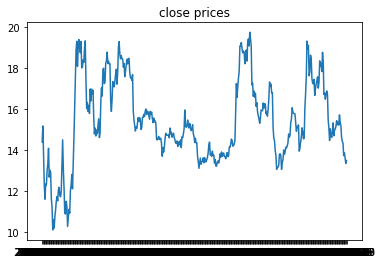

In [171]:
plt.plot(data_sorted.close)
plt.title('close prices')
plt.show()

### 将数据集分割为训练集和测试集

In [172]:
def train_test_split(data,SEQ_LENGTH = 25,test_prop=0.137):  # 0.11 for 1095, 0.137 for 730, 0.3 for 365
    
    ntrain = int(len(data) *(1-test_prop))  # len(data) = 197
    predictors = data.columns[:4]  # open, high, close, low
    data_pred = data[predictors]
    num_attr = data_pred.shape[1]  # 4
    
    result = np.empty((len(data) - SEQ_LENGTH, SEQ_LENGTH, num_attr))
    y = np.empty((len(data) - SEQ_LENGTH, SEQ_LENGTH))
    yopen = np.empty((len(data) - SEQ_LENGTH, SEQ_LENGTH))

    for index in range(len(data) - SEQ_LENGTH):
        result[index, :, :] = data_pred[index: index + SEQ_LENGTH]
        y[index, :] = data_pred[index+1: index + SEQ_LENGTH + 1].close
        yopen[index, :] = data_pred[index+1: index + SEQ_LENGTH + 1].open

    """
        xtrain的大小：ntrain x SEQ_LENGTH x 4
        ytrain的大小：ntrain x SEQ_LENGTH
        
        * xtrain的每个batch为长为SEQ_LENGTH的连续序列，一共有ntrain个batch，
          序列中每个单元都是一个四元组（open，high，close，low）
        * ytrain的每个batch为长为SEQ_LENGTH的连续序列，一共有ntrain个batch，
          序列中每个单元是xtrain中对应四元组所在日期的下一天的close price
        
        xtest 的大小：    ntest x SEQ_LENGTH x 4                
        ytest的大小：     ntest x SEQ_LENGTH      (close price)
        ytest_open的大小：ntest x SEQ_LENGTH      (open price)  
        
        * xtest的每个batch为长为SEQ_LENGTH的连续序列，一共有ntest个batch，
          序列中每个单元都是一个四元组（open，high，close，low）
          每一个序列仅包含一个新四元组，且在最后一个
        * ytest的每个batch为长为SEQ_LENGTH的连续序列，一共有ntest个batch，
          序列中每个单元是xtest中对应四元组所在日期的下一天的close price
        
        类型：numpy.ndarray
    """
    xtrain = result[:ntrain, :, :]
    ytrain = y[:ntrain]
    
    xtest = result[ntrain:, :, :]
    ytest = y[ntrain:]
    ytest_open = yopen[ntrain:]
    
    return xtrain, xtest, ytrain, ytest, ytest_open

In [173]:
xtrain, xtest, ytrain, ytest, ytest_open = train_test_split(data_sorted)

# 转为tensor
xtrain = torch.from_numpy(xtrain)
ytrain = torch.from_numpy(ytrain)

xtest = torch.from_numpy(xtest)
ytest = torch.from_numpy(ytest)

In [174]:
xtrain.shape

torch.Size([372, 25, 4])

In [175]:
ytrain.shape

torch.Size([372, 25])

In [176]:
xtest.shape

torch.Size([35, 25, 4])

In [177]:
ytest.shape

torch.Size([35, 25])

### 定义LSTM模型

In [178]:
class lstm(nn.Module):
    def __init__(self, input_size=4, hidden_size=30, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # 使用两层LSTMCell堆积来提高模型表达力
        self.layer1 = nn.LSTMCell(input_size=self.input_size, hidden_size=self.hidden_size)
        self.layer2 = nn.LSTMCell(input_size=self.hidden_size, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
        
    def forward(self, input_data, future=0):
        outputs = []
        
        # LSTM cell的三个输入：input(batch,input_size), h_0(batch,hidden_size), c_0(batch,hidden_size)
        # batch即为input_data中样本的数量，即为ntrain
        # 此处input_data的大小为：ntrain x SEQ_LENGTH X 4
        
        # init hidden states and cell state for layer1
        h_t = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double)
        c_t = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double)
        
        # init hidden states and cell state for layer2
        h_t2 = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double)
        c_t2 = torch.zeros(input_data.size(0), self.hidden_size, dtype=torch.double)
        
        # input_data:[ntrain x SEQ_LENGTH X 4]
        # chunk将tensor按第二个维度分成 SEQ_LENGTH 块
        for i, input_t in enumerate(input_data.chunk(input_data.size(1), dim=1)):
            
            # reshape: [ntrain x 1 x 4] => [ntrain x 4] 
            input_t = input_t.squeeze(1)
            
            # 每个input_t是 ntrain x 4 的tensor， batch=ntrain，input_size=4
            h_t, c_t = self.layer1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.layer2(h_t, (h_t2, c_t2))
            
            # output的大小为 ntrainx1
            output = self.linear(h_t2)
            outputs += [output]
            
        outputs = torch.stack(outputs, 1).squeeze(2)
        
        return outputs

### 训练LSTM模型

In [179]:
# 设置随机数种子
np.random.seed(0)
torch.manual_seed(0)

# 构建网络
lstm = lstm().double()
criterion = nn.MSELoss()

# 优化器
optimizer = optim.LBFGS(lstm.parameters(), lr=0.1)

# 开始训练    
for i in range(100):
    print('STEP: ', i)
    
    def closure():
        optimizer.zero_grad()
        out = lstm(xtrain)
        
        loss = criterion(out, ytrain)
        print('loss:', loss.item())
        loss.backward()
        return loss
    
    optimizer.step(closure)

STEP:  0
loss: 243.04767372383532
loss: 242.76888695536877
loss: 120.49625473004085
loss: 88.06123542644407
loss: 65.26858120740829
loss: 39.86613509627804
loss: 24.70366978212775
loss: 18.114301717361734
loss: 14.657525511377026
loss: 12.350904110410399
loss: 10.696967975074527
loss: 9.62220241649145
loss: 8.926996790281136
loss: 8.433184348075663
loss: 8.058310355246803
loss: 7.762303162434136
loss: 7.521625825270421
loss: 7.320783525808287
loss: 7.148906324409188
loss: 6.998018668141564
STEP:  1
loss: 6.862018625329199
loss: 6.735999033181634
loss: 6.615723769276842
loss: 6.4971091730852715
loss: 6.3754831932867715
loss: 6.244056913618609
loss: 6.089703090972256
loss: 5.87765665412801
loss: 5.49441059918623
loss: 5.161011535183601
loss: 5.0735465916673474
loss: 4.975688401334526
loss: 4.801338211064003
loss: 4.6093775711391025
loss: 4.3572155240606305
loss: 4.228833393195735
loss: 4.068736228578455
loss: 3.9290288749709896
loss: 3.8214824728100556
loss: 3.7256806258345665
STEP:  2
l

loss: 0.262179744388257
loss: 0.2619364573861213
loss: 0.2616701024004134
loss: 0.2614459673362366
loss: 0.26122157990243505
loss: 0.2610225707816812
loss: 0.2608109919427074
loss: 0.26061071042685374
loss: 0.2603674788668686
loss: 0.26013967807400484
loss: 0.25985806314145266
loss: 0.25961851021697463
loss: 0.2593663038349242
loss: 0.25918637805859107
loss: 0.25900863239932204
loss: 0.25886343900090486
loss: 0.2587072453053539
loss: 0.2585668190102766
STEP:  17
loss: 0.2584046729763848
loss: 0.2582546537973085
loss: 0.2580670997442987
loss: 0.25786813335001435
loss: 0.2577097412711723
loss: 0.257546236789385
loss: 0.257356378709245
loss: 0.25714501395658507
loss: 0.25690127869276486
loss: 0.25668168866312285
loss: 0.2564468838790202
loss: 0.2562588363811422
loss: 0.2560602154074926
loss: 0.2559079154820596
loss: 0.25575214395439944
loss: 0.2556303079770686
loss: 0.2555049253362367
loss: 0.25540068202515503
loss: 0.25529578845855244
loss: 0.25520530302016514
STEP:  18
loss: 0.255119185

loss: 0.24502042343295793
loss: 0.24498496150417942
loss: 0.24494704002924408
STEP:  32
loss: 0.24490702484027
loss: 0.24487805595811346
loss: 0.2448562467373963
loss: 0.24483373642682846
loss: 0.24481052963033997
loss: 0.2447871762555133
loss: 0.24476373816118666
loss: 0.24473996458475716
loss: 0.24471567594530316
loss: 0.24469018696885184
loss: 0.24466341678962059
loss: 0.24463002032684378
loss: 0.24459934693832996
loss: 0.24456259100028707
loss: 0.24452353553157488
loss: 0.2444802184193006
loss: 0.24443980141648358
loss: 0.24439889722970615
loss: 0.24435856698637023
loss: 0.24431457714901578
STEP:  33
loss: 0.2442730314794943
loss: 0.24423205361710373
loss: 0.2441883928472525
loss: 0.24414719769786628
loss: 0.24410174620404618
loss: 0.2440595664608531
loss: 0.24401370743866968
loss: 0.24397294464492858
loss: 0.24392845103792782
loss: 0.24388559171837632
loss: 0.24383869862997887
loss: 0.2437928185266126
loss: 0.24374347509648833
loss: 0.24369513092758835
loss: 0.24364453578955475
lo

loss: 0.2321322210061416
loss: 0.23208787828931593
loss: 0.23204565593066243
loss: 0.23200545174620768
loss: 0.23196736622451514
loss: 0.23193346387013025
loss: 0.23190109179776686
loss: 0.2318699450959871
loss: 0.2318422574707923
STEP:  48
loss: 0.23181180172155408
loss: 0.23178645939250986
loss: 0.231757223493632
loss: 0.23172857798230936
loss: 0.2317001387378722
loss: 0.23167090292793496
loss: 0.23163831782699612
loss: 0.23160399166630913
loss: 0.23156498547318424
loss: 0.2315228683287142
loss: 0.23147553385913003
loss: 0.231425112258824
loss: 0.23136983920080967
loss: 0.2313120753305138
loss: 0.2312500960902331
loss: 0.23118685275311612
loss: 0.2311212433109863
loss: 0.2310576743035131
loss: 0.23098820928846533
loss: 0.23091467981007113
STEP:  49
loss: 0.23084733520565884
loss: 0.23078145303855652
loss: 0.2307156849617978
loss: 0.23065043807927024
loss: 0.2305846803086062
loss: 0.23051969977877731
loss: 0.23045065458246886
loss: 0.23038122549137155
loss: 0.23031040121629484
loss: 0

loss: 0.212587290069394
loss: 0.21254967363042918
loss: 0.2125115032566643
loss: 0.21247563411067863
loss: 0.21243914517095516
loss: 0.2124038605742965
loss: 0.21235992061539175
loss: 0.21232721977127195
loss: 0.2122746641380561
loss: 0.21223353350096452
loss: 0.21217964284863866
loss: 0.2121151558262922
loss: 0.21203908453161321
loss: 0.2119554335710674
loss: 0.21186412229991797
STEP:  64
loss: 0.21176572589769382
loss: 0.21166395120956252
loss: 0.21156143999270613
loss: 0.21146274593338005
loss: 0.21136902427925938
loss: 0.21128314802377324
loss: 0.21120442730916583
loss: 0.2111326785739937
loss: 0.21106571007759126
loss: 0.21100280250984357
loss: 0.21094404544038353
loss: 0.21088690260485746
loss: 0.2108318611835339
loss: 0.2107683557537176
loss: 0.21071720018261936
loss: 0.21067816565974373
loss: 0.2106230264162615
loss: 0.2105674224855666
loss: 0.2105042894047768
loss: 0.21043098319736117
STEP:  65
loss: 0.21035014176994196
loss: 0.21026182061201554
loss: 0.21018057985376737
loss:

loss: 0.19408554099661657
STEP:  79
loss: 0.19404968229540834
loss: 0.1940090261440334
loss: 0.19396300595727625
loss: 0.19391375748939688
loss: 0.19386183604929735
loss: 0.19380813480932538
loss: 0.19375335169086125
loss: 0.19369816404390336
loss: 0.19364301382033133
loss: 0.19358818418076104
loss: 0.19353377380332434
loss: 0.19347970062560482
loss: 0.19342564889710337
loss: 0.19337107014274796
loss: 0.19331523304798542
loss: 0.19325727843684454
loss: 0.19319634170523436
loss: 0.19313191693833592
loss: 0.19306371391755356
loss: 0.19296680699371396
STEP:  80
loss: 0.19286894064663954
loss: 0.19278505229130963
loss: 0.19271713328341958
loss: 0.19264648880600957
loss: 0.19259321292544088
loss: 0.19253904718375023
loss: 0.1924778028744626
loss: 0.19242472052908294
loss: 0.1923728593297651
loss: 0.19232191540780882
loss: 0.1922672598105631
loss: 0.19220877197803976
loss: 0.192148418582715
loss: 0.19211064118141993
loss: 0.19206969906949753
loss: 0.1920206355743781
loss: 0.19197627619384114

loss: 0.18275217411495853
loss: 0.18271373806059552
loss: 0.18267541908334795
loss: 0.182635147421197
loss: 0.18259923454981122
loss: 0.18256881163440697
loss: 0.1825367642153311
STEP:  95
loss: 0.18250059697985813
loss: 0.18246022319880012
loss: 0.182410963401457
loss: 0.18238629288395455
loss: 0.1823621127655935
loss: 0.1823370641070102
loss: 0.1823124243797805
loss: 0.18228833825651106
loss: 0.1822645716484576
loss: 0.1822397937214245
loss: 0.1822173781924869
loss: 0.18219390466407226
loss: 0.1821679959444436
loss: 0.18214646579855842
loss: 0.18212481148761214
loss: 0.1820996857231903
loss: 0.18207769799971846
loss: 0.18205632602862168
loss: 0.18203335430562106
loss: 0.18200853650397927
STEP:  96
loss: 0.18198258282441265
loss: 0.18195575039617617
loss: 0.18192757223552655
loss: 0.18189819437014873
loss: 0.1818699366444666
loss: 0.18184266392853668
loss: 0.18181571210561281
loss: 0.18178987378842407
loss: 0.1817643447882595
loss: 0.1817411366804528
loss: 0.18171817542121754
loss: 0.

### 测试LSTM模型

In [180]:
with torch.no_grad():
    future = 0
    pred = lstm(xtest, future=future)
    loss = criterion(ytest, pred)
    print('test loss:', loss.item())

pred_data = pred.detach().numpy()
test_data = ytest.detach().numpy()

test loss: 0.3526043192400466


In [181]:
# 从每个batch的序列数据中提取出ground truth和预测值

gd_truth = []
pred_val = []

# 每个batch的序列数据中的最后一个是新来的数据，将每个batch中新来的值提取出来
for i in range(len(pred_data)):
    gd_truth.append(test_data[i][-1])
    pred_val.append(pred_data[i][-1])
    
gd_truth = np.array(gd_truth)
pred_val = np.array(pred_val)

In [182]:
print(gd_truth)
print(pred_val)

[18.78 18.32 16.72 16.8  16.49 16.72 16.89 16.73 15.48 15.08 14.47 15.04
 14.74 14.62 14.9  15.33 14.7  14.98 15.03 15.16 15.44 15.24 15.35 15.22
 15.72 15.36 15.19 14.62 14.43 14.34 13.73 13.86 13.61 13.35 13.49]
[18.06218396 19.04971281 18.42633738 16.42892356 16.5639499  16.47054157
 16.7352888  16.81982952 16.82513798 15.74364376 15.34960908 14.52004787
 15.01320342 14.94074995 14.64562703 14.92079014 14.98753012 14.63315823
 14.95614925 15.21952817 15.24878071 15.29520983 15.272119   15.33227883
 15.31979917 15.44377308 15.42522462 15.27124168 14.6759264  14.4390123
 14.20430407 13.60036276 13.63265744 13.87668874 13.47048979]


In [183]:
# 欧式距离

np.linalg.norm(gd_truth - pred_val)

3.075406234417704

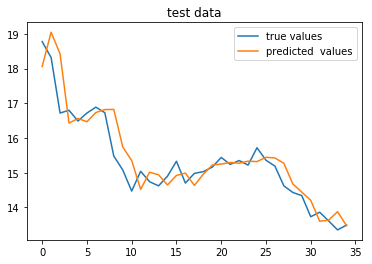

In [184]:
plt.plot(gd_truth, label='true values')
plt.plot(pred_val, label='predicted  values')
plt.legend()
plt.title('test data')
plt.show()